# 수강생분의 이름, 학번을 반영해주세요.

In [3]:
id = '20197132'
name = '주준하'
print(id, name)

20197132 주준하


코랩 메뉴 -> 수정 -> 노트 설정 -> 하드웨어 가속기 GPU 권장(행렬 연산이 많기 때문)

구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


폴더 경로 설정

In [5]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/CV_과제5'

필요 패키지 로드

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import random
import numpy as np
import matplotlib.pyplot as plt

결과 재현을 위한 seed 설정

In [7]:
seed = 719
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

합성곱 신경망(CNN) 정의

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3,
                      stride=1, padding=1, bias=False),  # 1x28x28 -> 10x28x28
            nn.BatchNorm2d(10),  # 배치 정규화
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3,
                      stride=1, padding=1, bias=False),  # 10x28x28 -> 20x28x28
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 20x28x28 -> 20x14x14 (특징 압축)
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3,
                      stride=1, padding=1, bias=False),  # 20x14x14 -> 40x14x14
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 40x14x14 -> 40x7x7 (특징 압축)
            nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3,
                      stride=1, padding=1, bias=False),  # 40x7x7 -> 80x7x7
            nn.BatchNorm2d(80),
            nn.AdaptiveAvgPool2d(1)  # 80x7x7 -> 80x1x1 (채널 별 평균값 계산)
        )
        self.fc = nn.Linear(80, 10)  # 출력값의 차원은 판별할 클래스 수인 10으로 설정 (MNIST는 손글씨 숫자 10종 판별 문제)

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 1, 28, 28)  # view 함수로 tensor 형태 변경: [batch크기, 1, 28, 28]
        x = self.main(x)  # CNN 모델 feed-forward
        x = x.view(-1, 80)  # view 함수로 형태 변경: [batch크기, 80]
        x = self.fc(x)  # 마지막 레이어에는 활성화 함수 사용하지 않음
        return x

print("init model done")

init model done


모델 학습을 위한 하이퍼파라미터 셋팅

In [9]:
batch_size = 64  # 학습 배치 크기
test_batch_size = 1000  # 테스트 배치 크기 (학습 과정을 제외하므로 더 큰 배치 사용 가능)
max_epochs = 10  # 학습 데이터셋 총 훈련 횟수
lr = 0.01  # 학습률
momentum = 0.5  # SGD에 사용할 모멘텀 설정 (파라미터 업데이트 시 관성 효과 사용)
log_interval = 200  # interval 때마다 로그 남김

use_cuda = torch.cuda.is_available()  # GPU cuda 사용 여부 확인

device = torch.device("cuda" if use_cuda else "cpu")  # GPU cuda 사용하거나 없다면 CPU 사용

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}  # num_workers: data loading할 프로세스 수, pin_memory: 고정된 메모리 영역 사용

print("set vars and device done")

set vars and device done


데이터 로더 정의 (학습용, 테스트용 따로 정의)

In [10]:
transform = transforms.Compose([
                 transforms.ToTensor(),  # numpy array -> tensor 변환
                 transforms.Normalize((0.5,), (0.5,))])  # 입력값 정규화 (일반적으로는 학습 데이터셋의 평균, 표준편차 사용)

# 학습용 데이터 로더 (MNIST 학습 데이터셋 사용)
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST(os.path.join(workspace_path, 'data'), train=True, download=True, 
                 transform=transform), 
    batch_size = batch_size, shuffle=True, drop_last=True, **kwargs)  # drop_last: 마지막 미니배치 크기가 batch_size 이하면 drop 

# 테스트용 데이터 로더 (MNIST 테스트 데이터셋 사용)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.join(workspace_path, 'data'), train=False, download=True,
                 transform=transform), 
    batch_size=test_batch_size, shuffle=False, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw/train-images-idx3-ubyte.gz to /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw/train-labels-idx1-ubyte.gz to /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /gdrive/My Drive/Colab Notebooks/CV_과제5/data/MNIST/raw



랜덤하게 선별한 30장 이미지 plot

<Figure size 432x288 with 0 Axes>

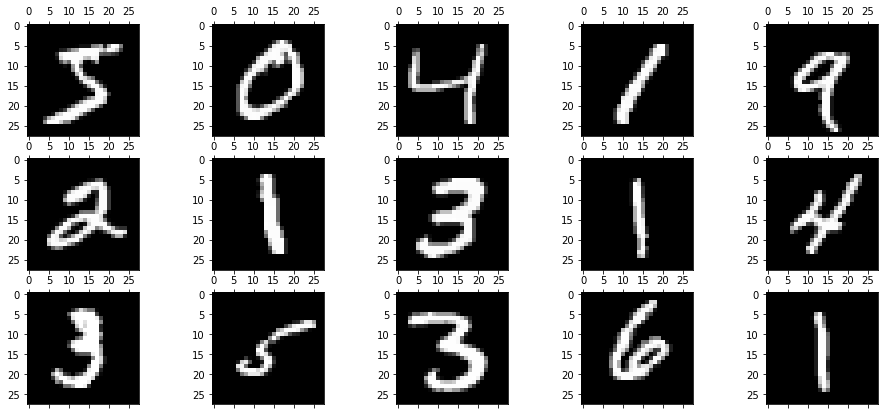

In [11]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    data, _ = train_loader.dataset[i]
    data = data.numpy()
    ax = fig.add_subplot(3,5,i+1, title="")
    ax.matshow(data.reshape((28,28)).astype(float))
plt.show()

모델, 최적화 알고리즘, 손실 함수 정의

In [12]:
model = Net().to(device)  # 모델 정의
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # 최적화 알고리즘 정의 (SGD 사용)
criterion = nn.CrossEntropyLoss()  # 손실 함수 정의 (CrossEntropy 사용)

AverageMeter 정의

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

학습, 테스트용 함수 정의

In [14]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()  # 모델 학습 모드 설정
    summary_loss = AverageMeter()  # 학습 손실값 기록 초기화
    summary_acc = AverageMeter() # 학습 정확도 기록 초기화
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
        optimizer.zero_grad()  # gradient 0으로 초기화
        output = model(data)  # 모델에 입력값 feed-forward
        loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답간의 손실값 계산
        loss.backward()  # 손실값 역전파 (각 계층에서 gradient 계산, pytorch는 autograd로 gradient 자동 계산)
        optimizer.step()  # 모델의 파라미터 업데이트 (gradient 이용하여 파라미터 업데이트)
        summary_loss.update(loss.detach().item())  # 손실값 기록
        pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
        correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
        summary_acc.update(correct / data.size(0))  # 정확도 기록
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}, Accuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()  # 모델 검증 모드 설정 (inference mode)
    summary_loss = AverageMeter()  # 테스트 손실값 기록 초기화
    summary_acc = AverageMeter() # 테스트 정확도 기록 초기화
    with torch.no_grad():  # 검증 모드이므로 gradient 계산안함
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
            output = model(data)  # 모델에 입력값 feed-forward
            loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답간의 손실값 계산
            summary_loss.update(loss.detach().item())  # 손실값 기록
            pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
            correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
            summary_acc.update(correct / data.size(0))  # 정확도 기록

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format
          (summary_loss.avg, summary_acc.avg))  # 정답을 맞춘 개수 / 테스트셋 샘플 수 -> Accuracy

    return summary_loss.avg, summary_acc.avg

학습, 테스트, 모델 저장 수행

In [15]:
for epoch in range(1, max_epochs+1):
    best_acc = 0
    best_epoch = 0
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

    # 테스트에서 best accuracy 달성하면 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch
        torch.save(model, os.path.join(workspace_path, f'mnist_cnn_model_best_acc_{best_epoch}-epoch.pt'))
        print(f'# save model: mnist_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

print(f'\n\n# Best accuracy model({best_acc * 100:.2f}%): mnist_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

Train Epoch: 1 [0/60000 (0%)]	Average loss: 2.312092, Accuracy: 0.078125
Train Epoch: 1 [12800/60000 (21%)]	Average loss: 1.757470, Accuracy: 0.403296
Train Epoch: 1 [25600/60000 (43%)]	Average loss: 1.411237, Accuracy: 0.553265
Train Epoch: 1 [38400/60000 (64%)]	Average loss: 1.139885, Accuracy: 0.659942
Train Epoch: 1 [51200/60000 (85%)]	Average loss: 0.950277, Accuracy: 0.725148

Test set: Average loss: 0.3163, Accuracy: 0.921400

# save model: mnist_cnn_model_best_acc_1-epoch.pt

Train Epoch: 2 [0/60000 (0%)]	Average loss: 0.271357, Accuracy: 0.921875
Train Epoch: 2 [12800/60000 (21%)]	Average loss: 0.245300, Accuracy: 0.945040
Train Epoch: 2 [25600/60000 (43%)]	Average loss: 0.223822, Accuracy: 0.950047
Train Epoch: 2 [38400/60000 (64%)]	Average loss: 0.208912, Accuracy: 0.952657
Train Epoch: 2 [51200/60000 (85%)]	Average loss: 0.197776, Accuracy: 0.954373

Test set: Average loss: 0.1535, Accuracy: 0.958200

# save model: mnist_cnn_model_best_acc_2-epoch.pt

Train Epoch: 3 [0/6000